In [134]:
import sklearn
import numpy as np
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# from gap_statistic.optimalK import OptimalK
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import xgboost as xgb
import lightgbm as lgb
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import Pool
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

In [135]:
train_df = pd.read_csv('csv_files/train.csv')
test_df = pd.read_csv('csv_files/test.csv')

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



## Check Missing Values

In [136]:
table = PrettyTable()

table.field_names = ['Column Name', 'Data Type', '# Null Values']
for column in train_df.columns:
    data_type = str(train_df[column].dtype)
    non_null_count = train_df[column].isnull().sum()
    table.add_row([column, data_type, non_null_count])
print(table)


+--------------+-----------+---------------+
| Column Name  | Data Type | # Null Values |
+--------------+-----------+---------------+
| PassengerId  |   object  |       0       |
|  HomePlanet  |   object  |      201      |
|  CryoSleep   |   object  |      217      |
|    Cabin     |   object  |      199      |
| Destination  |   object  |      182      |
|     Age      |  float64  |      179      |
|     VIP      |   object  |      203      |
| RoomService  |  float64  |      181      |
|  FoodCourt   |  float64  |      183      |
| ShoppingMall |  float64  |      208      |
|     Spa      |  float64  |      183      |
|    VRDeck    |  float64  |      188      |
|     Name     |   object  |      200      |
| Transported  |    bool   |       0       |
+--------------+-----------+---------------+


## Where are the missing values

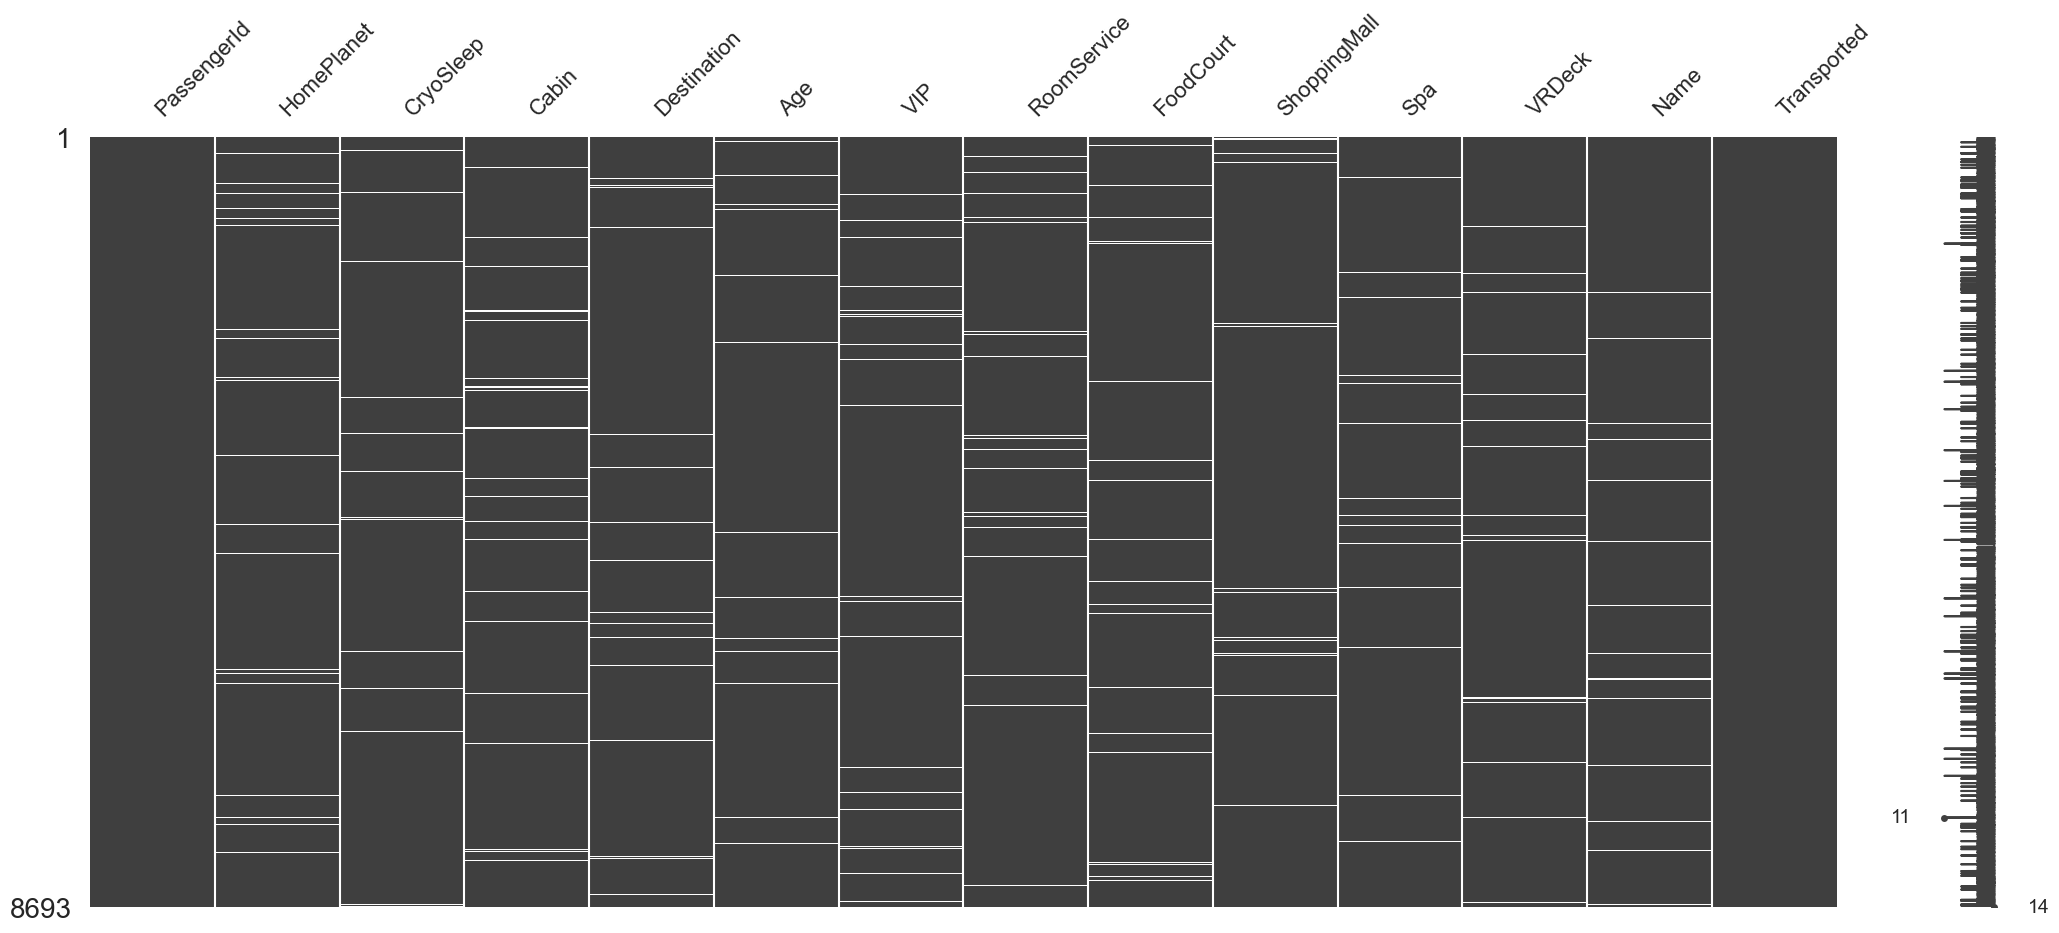

In [137]:
msno.matrix(train_df)
plt.show()

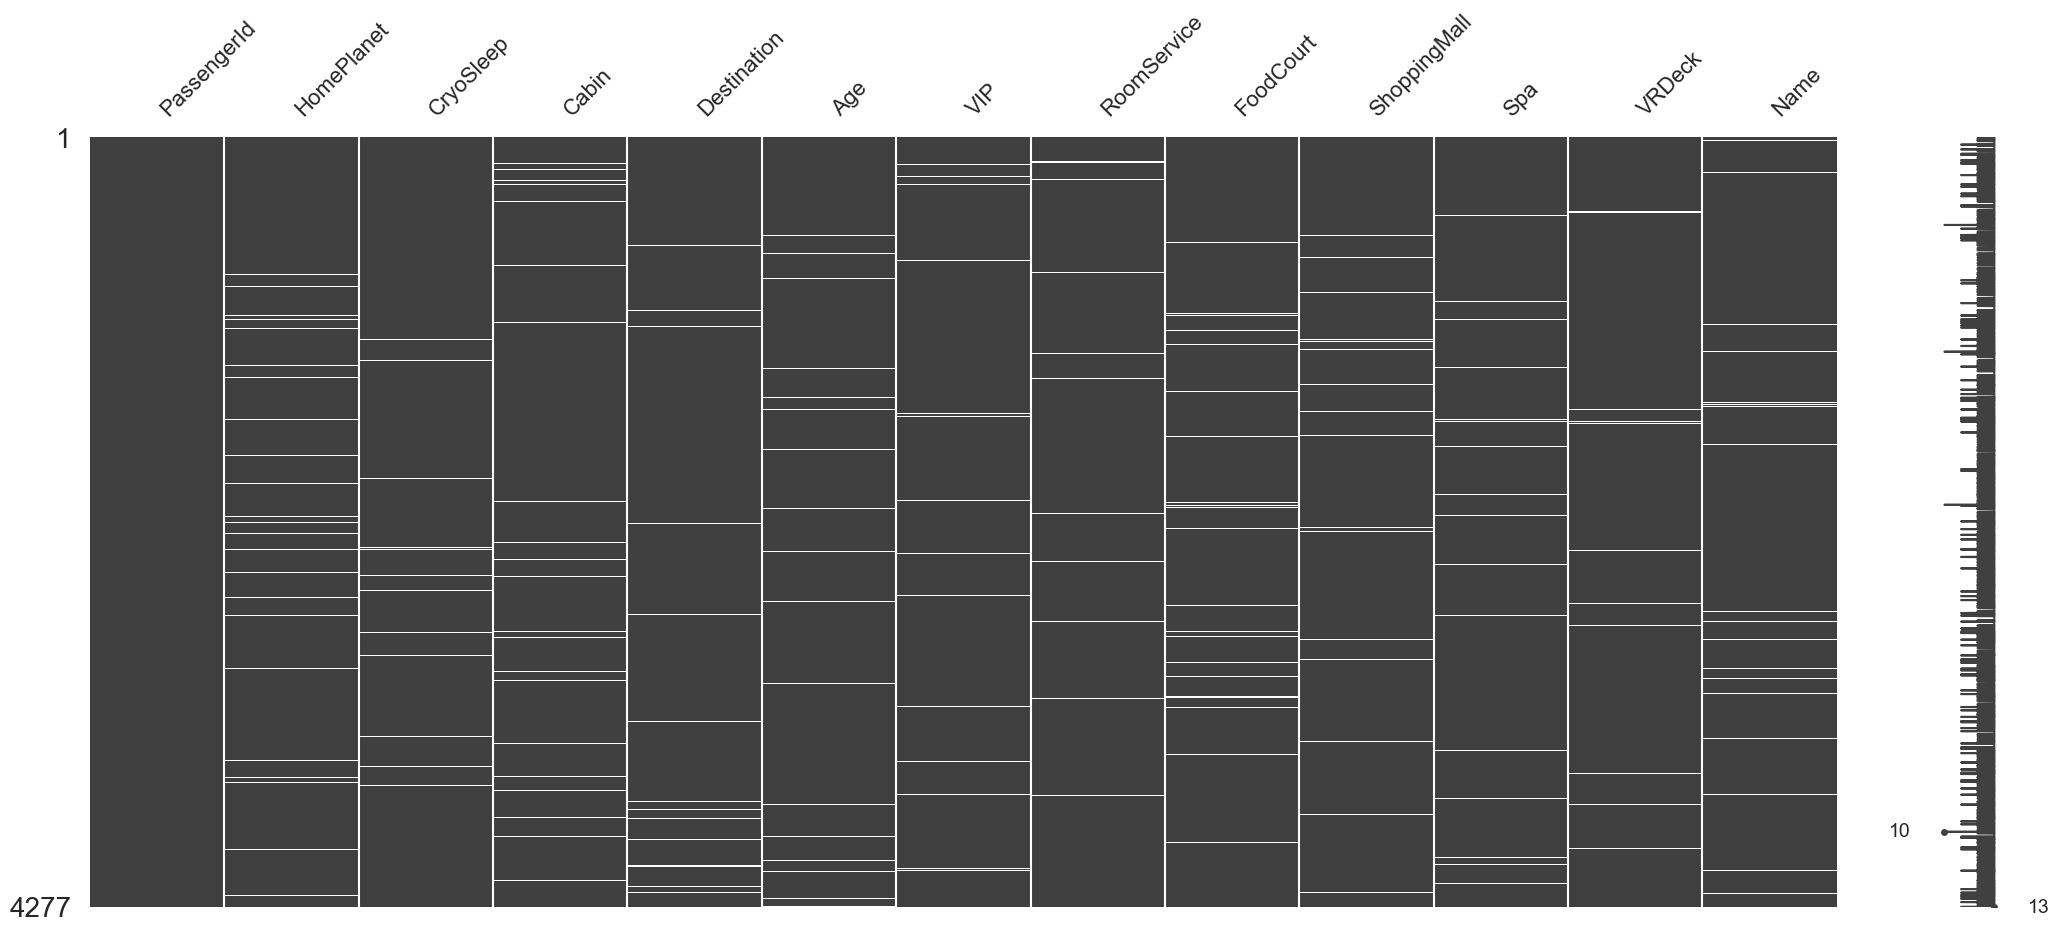

In [138]:
msno.matrix(test_df)
plt.show()

# Exploritary Data Analysis

## Target Analysis

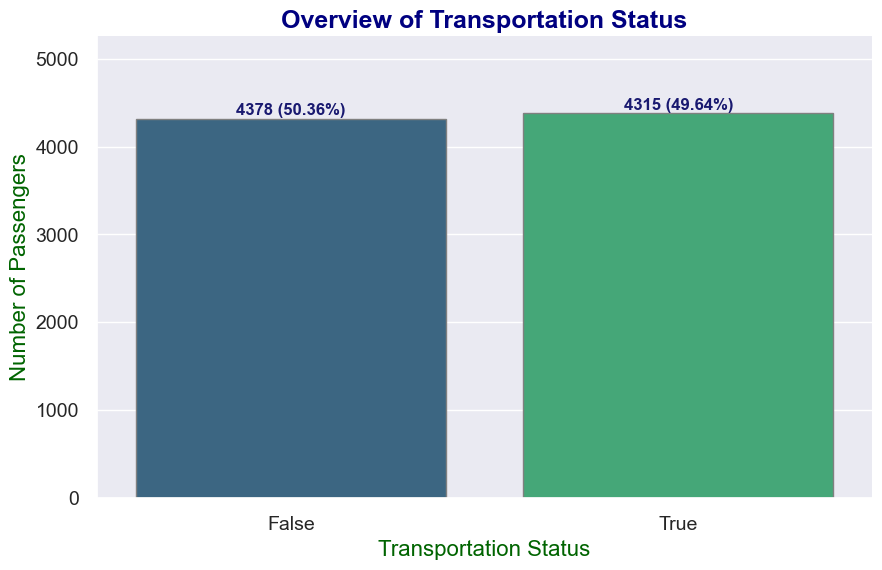

In [139]:
# Compute class proportions
transported_counts = train_df['Transported'].value_counts()
total_entries = train_df.shape[0]
proportions = (transported_counts / total_entries)

# Generate annotations for each bar
annotations = [f'{count} ({prop:.2%})' for count, prop in zip(transported_counts, proportions)]

# Choose a vibrant color palette
color_scheme = sns.color_palette('viridis', n_colors=len(transported_counts))

# Initialize the plot
plt.figure(figsize=(10, 6))
bar_plot = sns.countplot(x='Transported', data=train_df, palette=color_scheme, edgecolor='gray')

# Customizing the plot with a title and axis labels
plt.title('Overview of Transportation Status', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Transportation Status', fontsize=16, color='darkgreen')
plt.ylabel('Number of Passengers', fontsize=16, color='darkgreen')

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=14)

# Setting custom ylim for annotation space
plt.ylim(0, max(transported_counts) * 1.2)

# Annotate bars with class count and proportion information
for idx, patch in enumerate(bar_plot.patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2., height + 5, annotations[idx],
             ha='center', va='bottom', fontsize=12, color='midnightblue', fontweight='bold')

# Remove top and right spines
sns.despine()

# Display the plot
plt.show()


The data is balanced so accuracy will be a good metric to choose while building models

## Train & Test Data Distributions

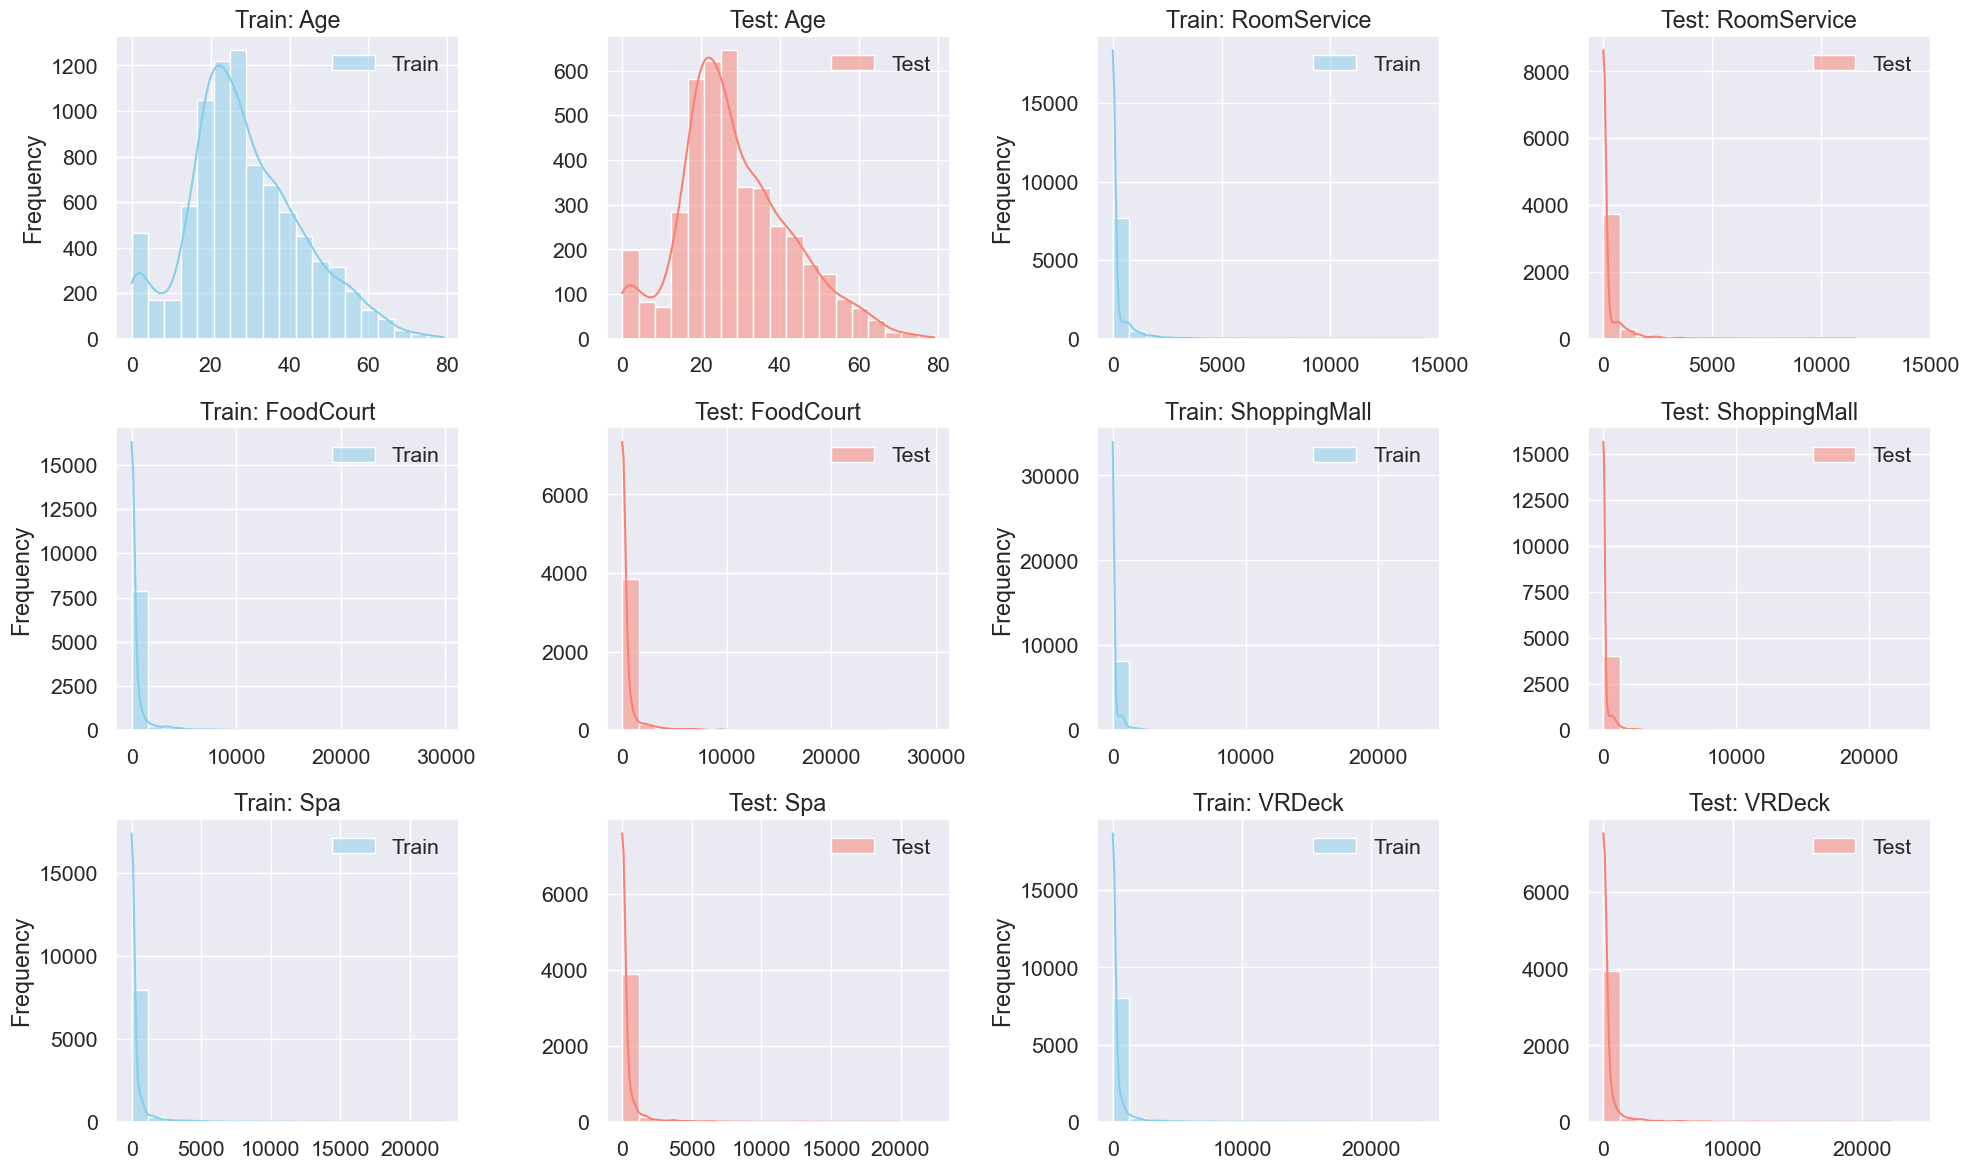

In [140]:
cont_cols=[f for f in train_df.columns if train_df[f].dtype in [float,int] and train_df[f].nunique()>3]

# Create a single row of subplots, with two plots for each continuous column (one for train and one for test)
fig, axs = plt.subplots(3, 4, figsize=(20, 12))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Iterate through the continuous columns and their corresponding axes
for i, col in enumerate(cont_cols):
    # Compute shared range and bin settings for both train and test histograms
    combined_max = np.max([train_df[col].max(), test_df[col].max()])
    combined_min = np.min([train_df[col].min(), test_df[col].min()])
    bins = np.linspace(combined_min, combined_max, 20)

    # Plot histogram for the training dataset on the left
    sns.histplot(train_df[col], ax=axs[i * 2], bins=bins, color='skyblue', kde=True, label='Train')
    axs[i * 2].set_title(f'Train: {col}')
    axs[i * 2].set_xlabel('')
    axs[i * 2].set_ylabel('Frequency')
    axs[i * 2].legend()

    # Plot histogram for the testing dataset on the right
    sns.histplot(test_df[col], ax=axs[i * 2 + 1], bins=bins, color='salmon', kde=True, label='Test')
    axs[i * 2 + 1].set_title(f'Test: {col}')
    axs[i * 2 + 1].set_xlabel('')
    axs[i * 2 + 1].set_ylabel('')
    axs[i * 2 + 1].legend()

# If the number of plots is not a multiple of the grid size, hide the unused axes
for j in range(i * 2 + 2, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

From the distributions of the continuous features, one thing we can clearly understand is that they are skewed and have outliers. So, we can consider options like log transformations

## Train Data Distributions across Classes

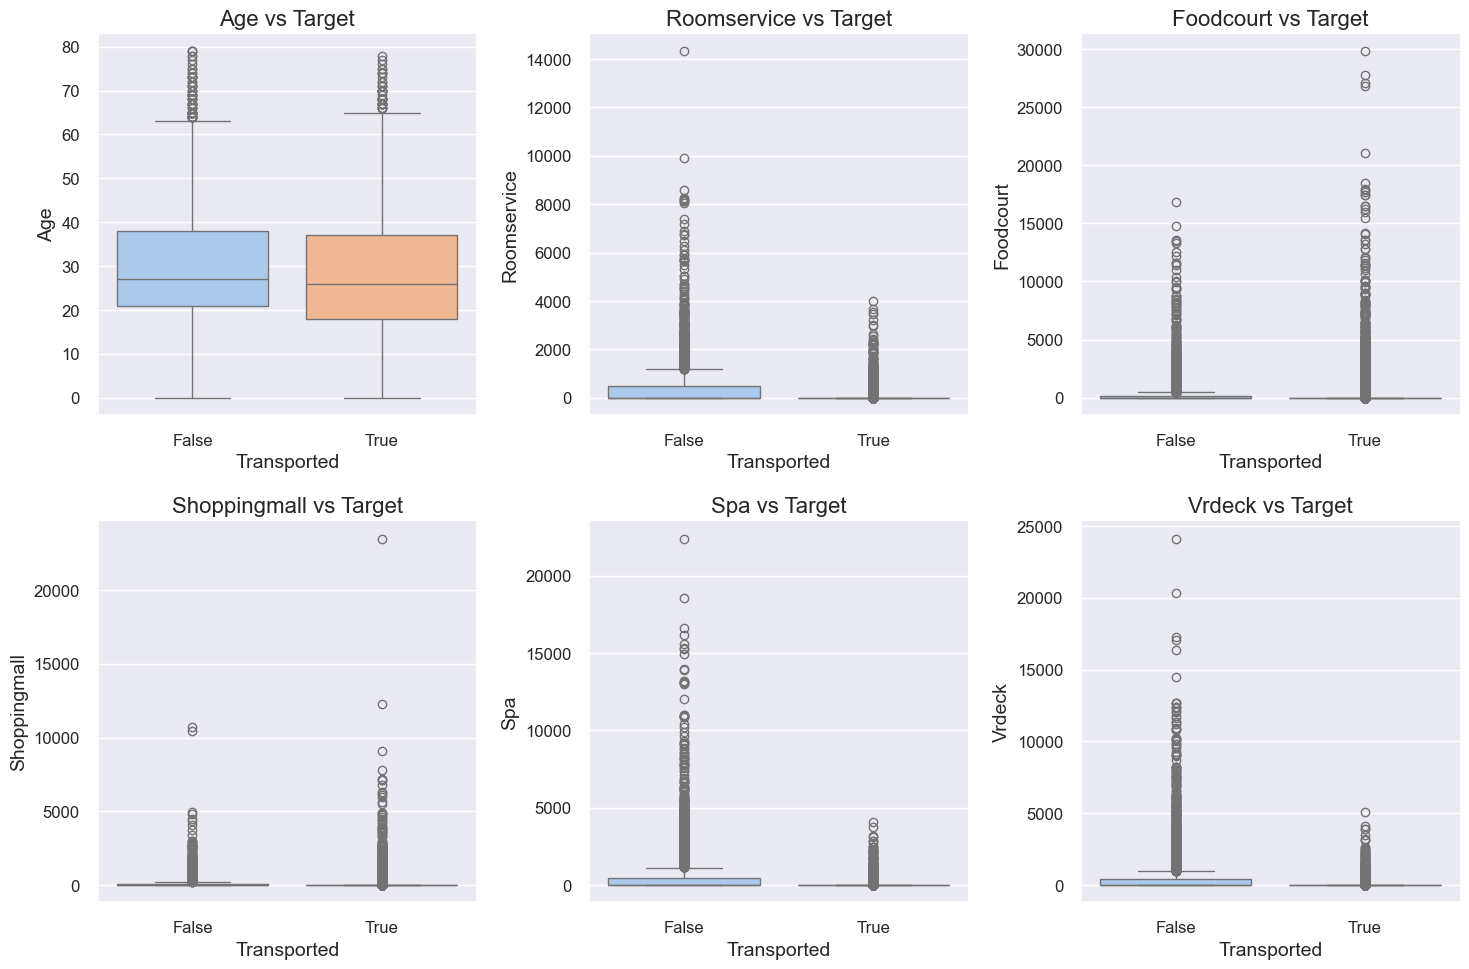

In [141]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate over them

# Iterate through each continuous column and plot boxplots
for i, col in enumerate(cont_cols[:6]):
    sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i], palette='pastel')
    axs[i].set_title(f'{col.title()} vs Target', fontsize=16)
    axs[i].set_xlabel('Transported', fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)
    axs[i].tick_params(axis='both', labelsize=12)
    sns.despine()

# If there are fewer than 6 continuous columns, hide the unused subplots
for j in range(i + 1, 6):
    axs[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Distributions between both the classes tell us that using these features directly into model would hinder the performance.
These are the things that we could try:
1. Create Bins
2. Use algorithms that are unaffected by outliers

## Bivariate Analysis

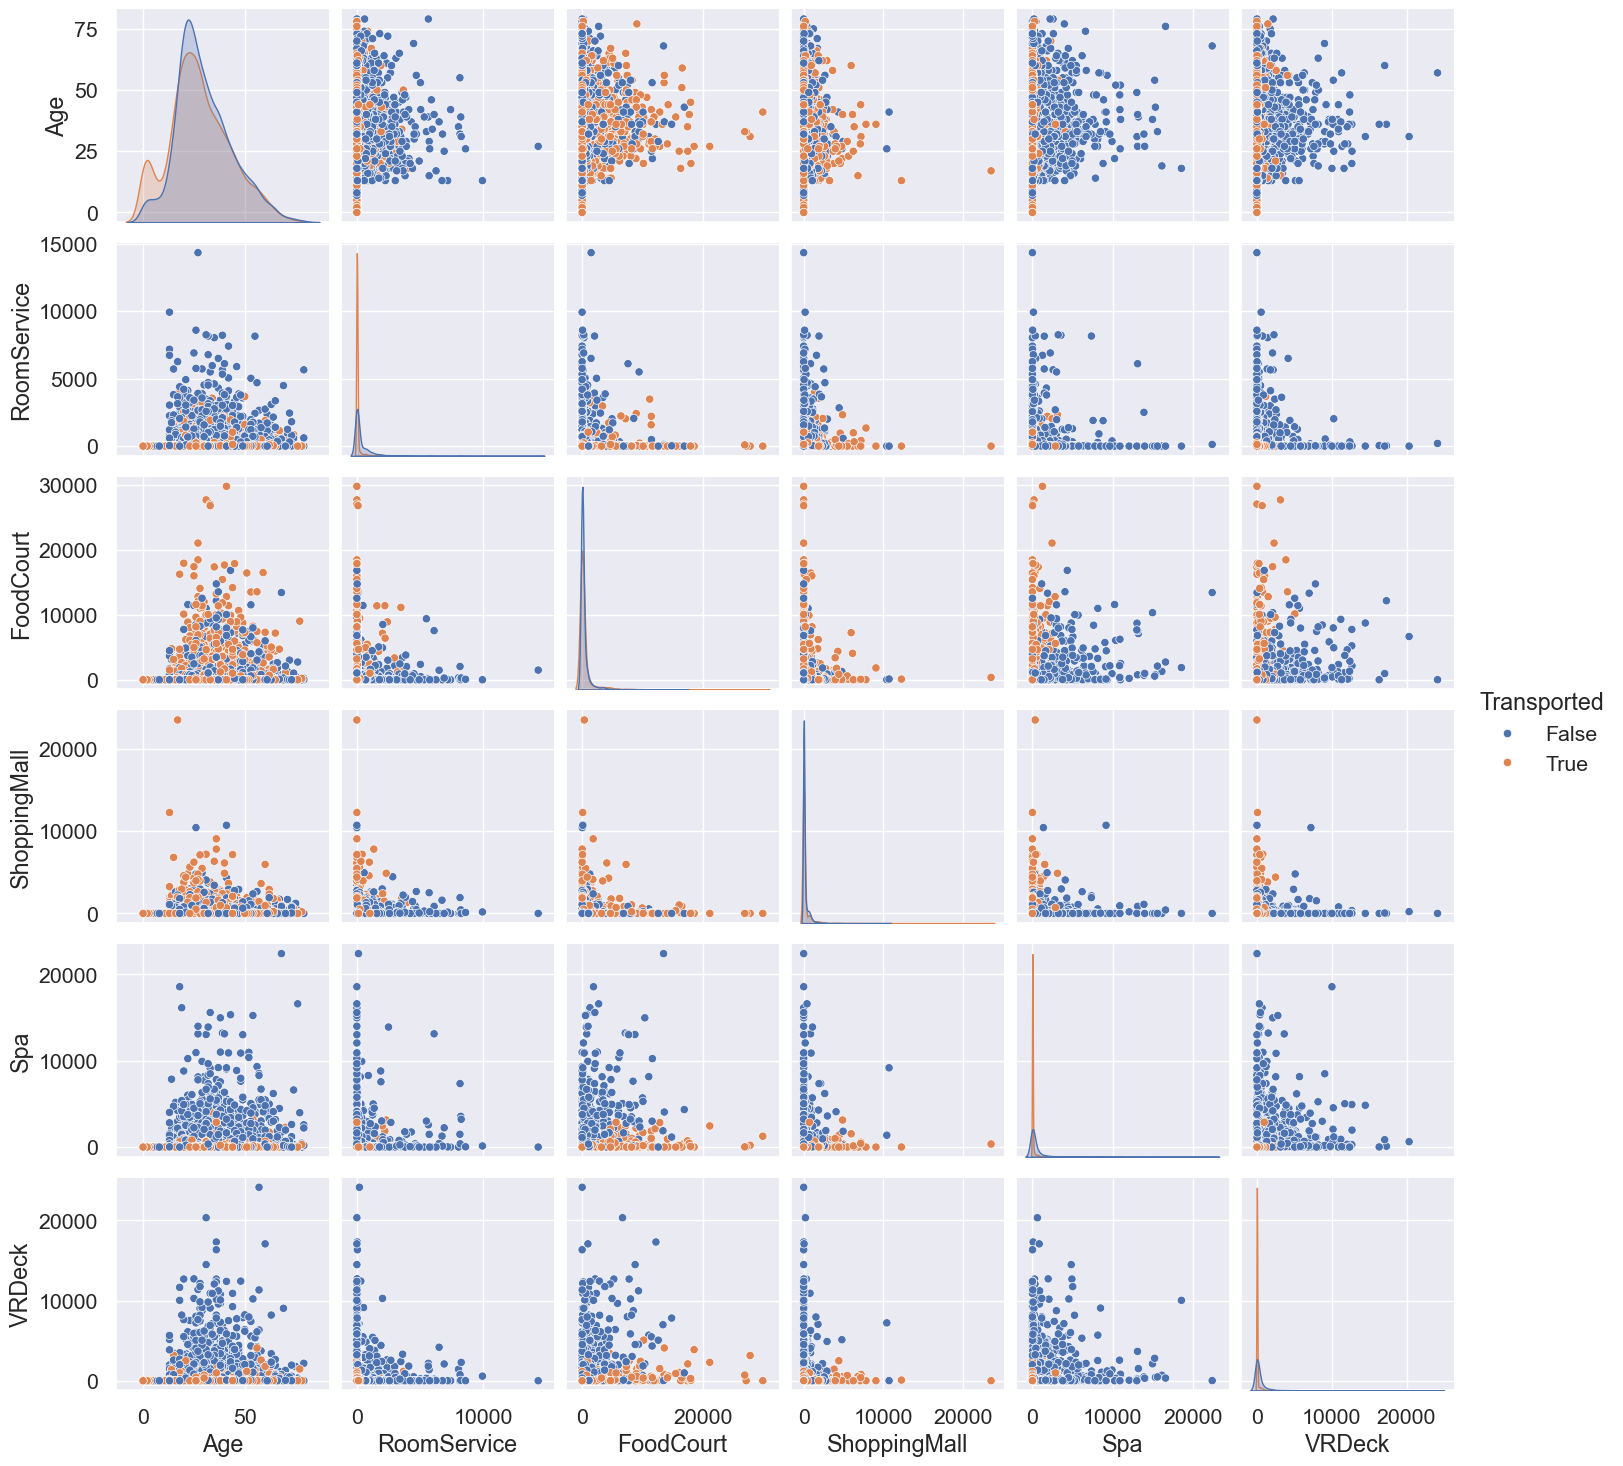

In [142]:
sns.pairplot(data=train_df, vars=cont_cols, hue='Transported')
plt.show()


**Inferences:**
1. The plot of Spa vs VRDeck has a good seperation between the classes. It's very clear that people who had spent less money on these were mostly Transported. 
2. The above statement holds true for Spa vs RoomService.
3. VRDeck, Spa, RoomService have a good differentiation between classes. 
4. We can create a new feature that tells the total expenditure in the above three features. 

### Create Violin plot to further show distribution between classes

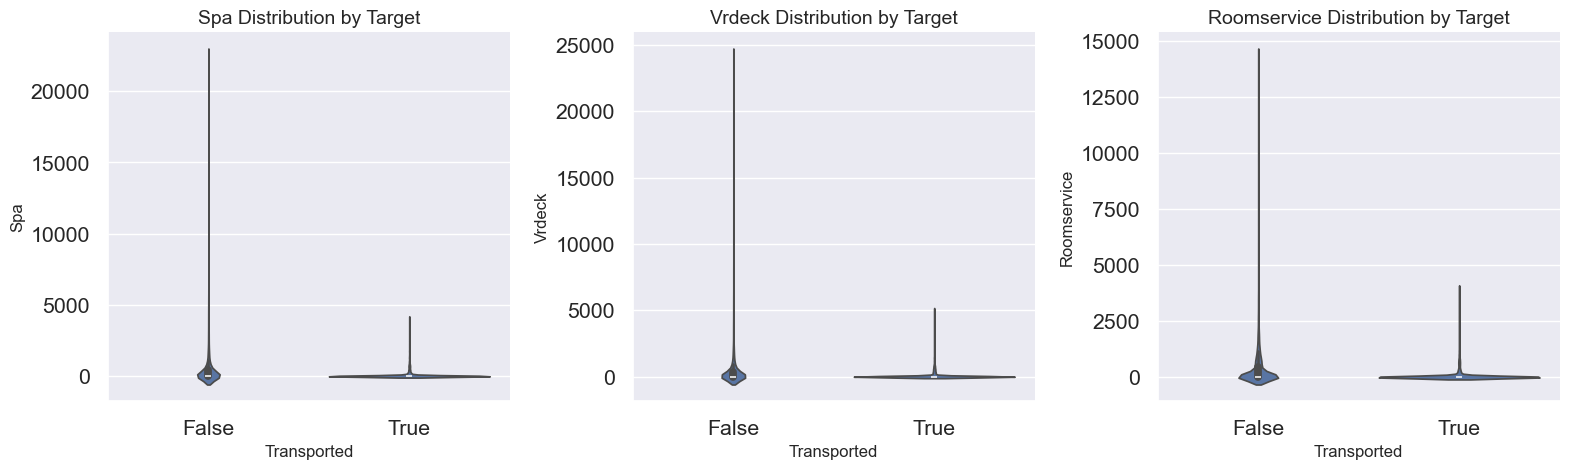

In [143]:
# Define the numerical features to plot
features=["Spa","VRDeck","RoomService"]

# Create a figure with multiple subplots
fig, axs = plt.subplots(1, len(features), figsize=(16, 5))

# Loop through each feature and plot a violin plot on a separate subplot
for i, col in enumerate(features):
    sns.violinplot(x='Transported', y=col, data=train_df, ax=axs[i])
    axs[i].set_title(f'{col.title()} Distribution by Target', fontsize=14)
    axs[i].set_xlabel('Transported', fontsize=12)
    axs[i].set_ylabel(col.title(), fontsize=12)
    sns.despine()

# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

## Correlation

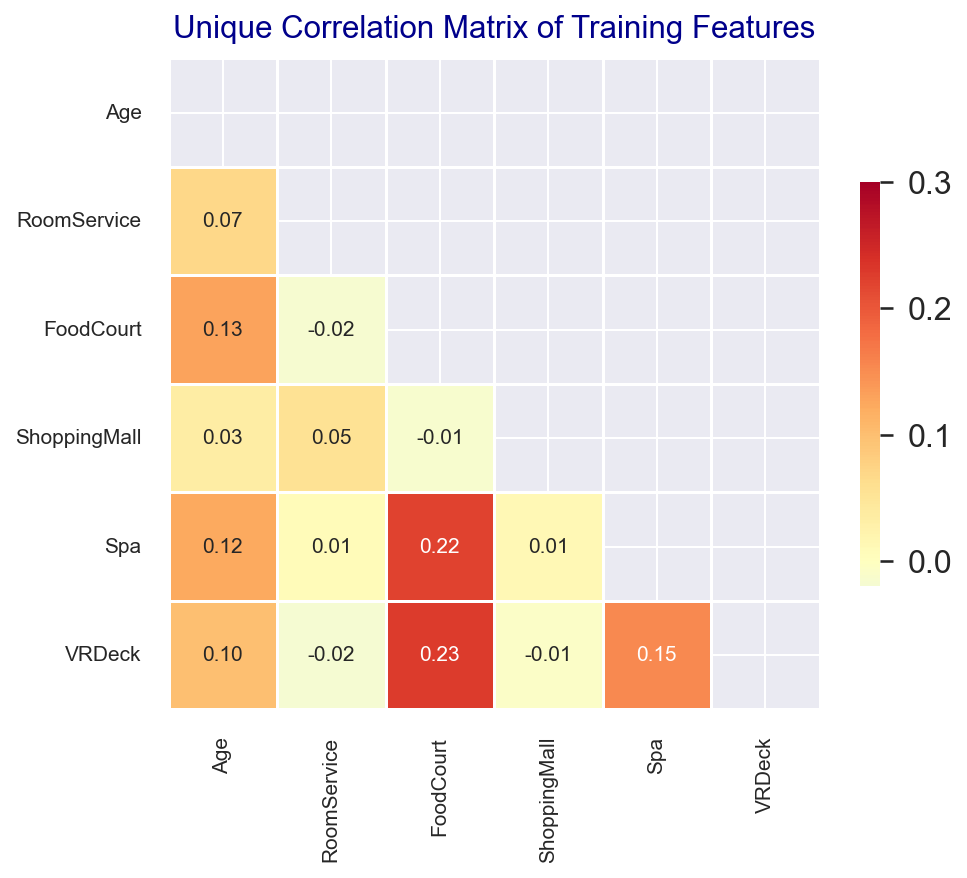

In [144]:
# Filtering for numeric features while excluding a specific column
numeric_features = [column for column in train_df.select_dtypes(include=[np.number]).columns if column not in ['Transported']]

# Calculating the correlation matrix for the numeric features
correlation_matrix = train_df[numeric_features].corr()

# Setting up the matplotlib figure with adjusted DPI for better resolution
plt.figure(figsize=(7, 7), dpi=150)
colormap = sns.color_palette("RdYlBu_r", as_cmap=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=colormap, vmax=.3, center=0,
            square=True, linewidths=.5, annot_kws={'size': 10}, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Adding a title with custom styling
plt.title('Unique Correlation Matrix of Training Features', fontsize=15, color='darkblue', pad=10)

# Reduce font size for x and y axis labels
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

# Displaying the plot
plt.show()

We can see that they are correlated only to a litlle extent however, our feature engineering techniques might create highly correlated features</font>

## Categorical/Discrete Analysis

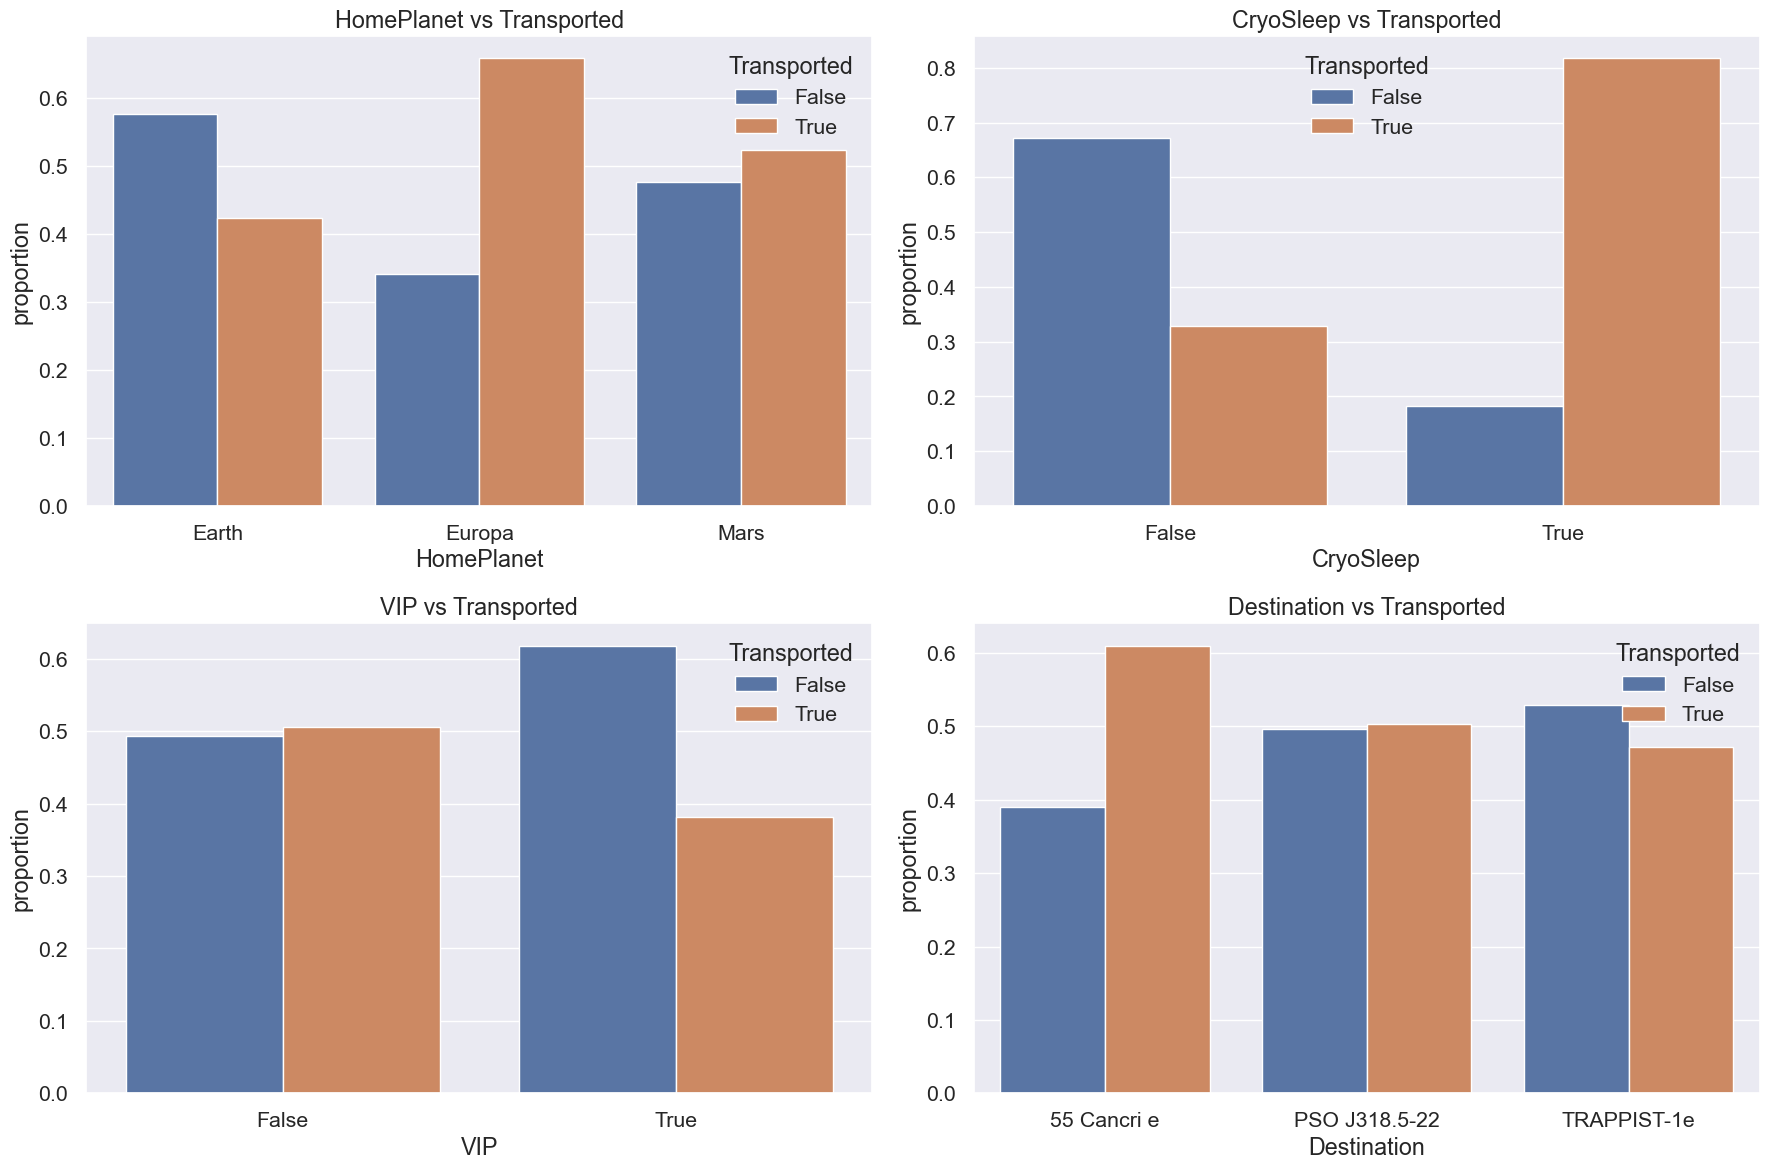

In [145]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

# List of features to plot
features = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination']

for i, feature in enumerate(features):
    # Calculate proportions
    prop_df = (train_df.groupby(feature)['Transported']
               .value_counts(normalize=True)
               .rename('proportion')
               .reset_index())

    # Plotting
    sns.barplot(x=feature, y='proportion', hue='Transported', data=prop_df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{feature} vs Transported')

plt.tight_layout()
plt.show()

**Inferences**
1. Less number of people from Earth are saved 
2. Cryosleep has good difference in proportions, poeple who are in Cryosleep are  more likely to be Transported
3. All the categories have differences in distributions in the classes


# Data Cleaning

## Passenger Group & Cabin

1. **Passenger Group**: Since it is mentioned in the problem statement that Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. **Cabin**: Cabin has the format Deck/Number/Side.

In [146]:
# Function to extract deck, number, and side from the Cabin column
def extract_features_from_cabin(cabin):
    if pd.isnull(cabin):
        return 'Missing_Deck', None, 'Missing_Side'
    deck, number, side = cabin.split('/')
    return deck, int(number), side

def extract_cabin_features(df):
    # Extract the passenger group from the PassengerId
    df["Group"] = df["PassengerId"].str.split("_").str[0].astype(int)

    # Apply the extraction function to the Cabin column
    df[['Deck', 'CabinNumber', 'Side']] = df.apply(lambda row: extract_features_from_cabin(row['Cabin']), axis=1, result_type='expand')

    # Drop the original Cabin column
    df.drop(columns=["Cabin"], inplace=True)

# Apply the function to both the train and test datasets
extract_cabin_features(train_df)
extract_cabin_features(test_df)

# Displaying the modified DataFrame as an example
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,CabinNumber,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1.0,S


## Catagorical Adjustments

In [147]:
def extract_and_assign_last_names(df):
    # Fill missing names with a placeholder
    df['Name'] = df['Name'].fillna("No_Name")

    # Function to extract the last name, handling edge cases
    def extract_last_name(name):
        name_parts = name.strip().lower().split(" ")
        return name_parts[-1] if name_parts else 'No_Name'

    # Apply the function to extract last names
    df['LastName'] = df['Name'].apply(extract_last_name)

# Apply the function to both DataFrames
extract_and_assign_last_names(train_df)
extract_and_assign_last_names(test_df)

# Verify there are no missing last names
print(train_df['LastName'].isna().sum(), test_df['LastName'].isna().sum())

0 0


In [148]:
def convert_bool_to_numeric(df, columns):
    for column in columns:
        if column in df.columns:
            # Convert boolean to int directly, NaNs will remain as NaN
            df[column] = df[column].astype(float)

# Specify the boolean columns to convert
bool_columns = ['VIP', 'CryoSleep', 'Transported']

# Apply the conversion to both DataFrames
convert_bool_to_numeric(train_df, bool_columns)
convert_bool_to_numeric(test_df, bool_columns[:2]) # Since test does not have 'Transported' 

# Checking the conversion
train_df.head()
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,CabinNumber,Side,LastName
0,0013_01,Earth,1.0,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13,G,3.0,S,carsoning
1,0018_01,Earth,0.0,TRAPPIST-1e,19.0,0.0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,18,F,4.0,S,peckers
2,0019_01,Europa,1.0,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,19,C,0.0,S,unhearfus
3,0021_01,Europa,0.0,TRAPPIST-1e,38.0,0.0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,21,C,1.0,S,caltilter
4,0023_01,Earth,0.0,TRAPPIST-1e,20.0,0.0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,23,F,5.0,S,harperez


## Handling Missing Values

### Missing Categorical features

In [149]:
miss_cat=[feature for feature in train_df.columns if train_df[feature].isnull().sum()>0 and train_df[feature].dtype=='O']

print('Categorical features with missing data: ', miss_cat)
print()

# Calculate the missing percentages for both train and test data
train_missing_pct = train_df[miss_cat].isnull().mean() * 100
test_missing_pct = test_df[miss_cat].isnull().mean() * 100

# Combine the missing percentages for train and test data into a single dataframe
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train', 'Test'])

# Print the missing percentage dataframe
print('Percentage missing: \n\n',missing_pct_df)

Categorical features with missing data:  ['HomePlanet', 'Destination']

Percentage missing: 

                 Train      Test
HomePlanet   2.312205  2.034136
Destination  2.093639  2.151040


In [150]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,CabinNumber,Side,LastName
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0.0,P,ofracculy
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,2,F,0.0,S,vines
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,3,A,0.0,S,susent
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,3,A,0.0,S,susent
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,4,F,1.0,S,santantines


In [151]:
for feature in miss_cat:
    train_df[feature].fillna("missing",inplace=True)
    test_df[feature].fillna("missing",inplace=True)
    
# Calculate the missing percentages for both train and test data
train_missing_pct = train_df[miss_cat].isnull().mean() * 100
test_missing_pct = test_df[miss_cat].isnull().mean() * 100

# Combine the missing percentages for train and test data into a single dataframe
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train', 'Test'])

# Print the missing percent
print('Percentage missing: \n\n', missing_pct_df)

Percentage missing: 

              Train  Test
HomePlanet     0.0   0.0
Destination    0.0   0.0


### Missing Numerical features

In [152]:
miss_cont=[feature for feature in train_df.columns if train_df[feature].isnull().sum()>0 and train_df[feature].dtype!='O' and feature not in ['Transported']]

print('Categorical features with missing data: ', miss_cont)
print()

# Calculate the missing percentages for both train and test data
train_missing_pct = train_df[miss_cont].isnull().mean() * 100
test_missing_pct = test_df[miss_cont].isnull().mean() * 100

# Combine the missing percentages for train and test data into a single dataframe
missing_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])

# Print the missing percentage dataframe
print('Percentage missing: \n\n',missing_df)

Categorical features with missing data:  ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNumber']

Percentage missing: 

                Train %     Test%
CryoSleep     2.496261  2.174421
Age           2.059128  2.127660
VIP           2.335212  2.174421
RoomService   2.082135  1.917232
FoodCourt     2.105142  2.478373
ShoppingMall  2.392730  2.291326
Spa           2.105142  2.361468
VRDeck        2.162660  1.870470
CabinNumber   2.289198  2.338087


Most of the features are expenditure features and my hypothesis is that if someone is in CryoSleep, it is not possible to spend money in these activities.

In [153]:
# First lets fill CryoSleep, based on totdal expenditure
expense_columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df["Expenditure"] = train_df[expense_columns].sum(axis="columns")
test_df["Expenditure"] = test_df[expense_columns].sum(axis="columns")

# Zero expenditure indicate that they are in CryoSleep
train_df['CryoSleep'] = np.where(train_df['Expenditure']==0,1,0)
test_df['CryoSleep']  =np.where(test_df['Expenditure']==0,1,0)

# Also, if they are VIPs, they probably would not choose to be in CryoSleep
train_df['VIP'] = np.where(train_df['CryoSleep']==0,1,0)
test_df['VIP']  =np.where(test_df['CryoSleep']==0,1,0)

train_df.drop(columns=["Expenditure"],inplace=True)
test_df.drop(columns=["Expenditure"],inplace=True)

In [154]:
for col in expense_columns:
    train_df[col]=np.where(train_df["CryoSleep"]==1,0,train_df[col])
    test_df[col]=np.where(test_df["CryoSleep"]==1,0,test_df[col])    
    
# Calculate the missing percentages for both train and test data
train_missing_pct = train_df[miss_cont].isnull().mean() * 100
test_missing_pct = test_df[miss_cont].isnull().mean() * 100

# Combine the missing percentages for train and test data into a single dataframe
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])

# Print the missing percentage dataframe
print(missing_pct_df)

               Train %     Test%
CryoSleep     0.000000  0.000000
Age           2.059128  2.127660
VIP           0.000000  0.000000
RoomService   1.184861  1.239186
FoodCourt     1.173358  1.519757
ShoppingMall  1.150351  1.402852
Spa           1.288393  1.169044
VRDeck        1.173358  0.958616
CabinNumber   2.289198  2.338087


Now we have filled almost many of them, the rest can be filled with KNN Imputer